# **Uvod**

**Student: Kosta Milošev IT52-2018 <br>
Predmet: Principi prezentacije i prepoznavanja oblika <br>
Tema projektnog zadatka: Detekcija godina, pola i emocija <br>**

***

  Duboko učenje poznatije i kao hijerarhijsko učenje, deo je šire porodice metoda mašinskog učenja koje su bazirane na učenju reprezentacije podataka, nasuprot algoritmima koji se baziraju na listama naredbi. 

  Neke reprezentacije podsećaju na interpretaciju obrade informacija i na šablonske komunikacije u biološkom nervnom sistemu, kao što je nervno kodiranje koje definiše vezu između različitih draži i odgovarajućeg nervnog odgovora u mozgu.

  Duboko učenje je našlo primenu na poljima računarskog vida, prepoznavanja govora, obrade prirodnih jezika, prepoznavanje zvuka i tako dalje.
  
***

Na samom početku projekta izvršeno je pretprocesiranje kompletnog dataset-a iz nekoliko razloga:

1. NEKE SLIKE SU OŠTEĆENE
2. SLIKE SU RAZLIČITIH VELIČINA 
3. NA POJEDINIM SLIKAMA NEMA LICA 
4. PODACI NISU PRAVILNO BALANSIRANI (više ima muških nego ženskih lica)
5. META PODACI SU U .MAT FORMATU, A TREBALI BI DA BUDU U .CSV

***

U projektu je izvršena filtracija podataka tako da su oni smešteni u odgovarajućem formatu. Nakon toga je izvršena konverzija .mat fajla u .csv format. Kada je fajl uspešno kreiran, na osnovu njega je izvršeno kreiranje modela, koji je treniran i testiran pomoću odgovarajućih algoritama. 
Među podacima nije postojala informacija o emocijama, te je u te svrhe korišćena druga metodologija kako bi se ispunio i taj trećinski deo projekta.



# **Priprema podataka**

Prvo je potrebno učitati dataset, koji se nalazi na Drive-u i koji nosi naziv dataset.zip.

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ztlCf2S68-k4ulB05gWsxGZtbU98jIx_' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ztlCf2S68-k4ulB05gWsxGZtbU98jIx_" -O images.zip && rm -rf /tmp/cookies.txt

Nakon što je dataset učitan, neophodno ga je unzipovati.

In [ ]:
!unzip images.zip

Sledeća ćelija prikazuje učitavanje .mat fajla sa meta podacima.

In [ ]:
from scipy.io import loadmat

loadmat('/content/wiki_crop/wiki.mat')

Fajl uspešno učitan, sledi njegova konverzija u .csv format. Za konverziju neophodno je učitati sledeće biblioteke:
1.   numpy - podržava nizove i matrice
2.   scipy.io - sadrži loadmat funkciju
3.   pandas - reprezentacija i manipulacija podacima
4.   datetime - rad sa datumima
5.   dateutil.relativedelta - razlika između dva datuma



In [ ]:
import numpy as np 
from scipy.io import loadmat
import pandas as pd 
import datetime as date
from dateutil.relativedelta import relativedelta 

#dat je prikaz kolona u .csv fajlu
cols = ['age', 'gender', 'path', 'face_score1', 'face_score2']

#putanja do wiki.mat fajla
wiki_mat = '/content/wiki_crop/wiki.mat'

#učitavanje .mat fajla
wiki_data = loadmat(wiki_mat)

#brisanje wiki.mat fajla
del wiki_mat

wiki = wiki_data['wiki']

wiki_photo_taken = wiki[0][0][1][0]
wiki_full_path = wiki[0][0][2][0]
wiki_gender = wiki[0][0][3][0]
wiki_face_score1 = wiki[0][0][6][0]
wiki_face_score2 = wiki[0][0][7][0]

wiki_path = []

for path in wiki_full_path:
    wiki_path.append('wiki_crop/' + path[0])

wiki_genders = []

for n in range(len(wiki_gender)):
    if wiki_gender[n] == 1:
        wiki_genders.append('male')
    else:
        wiki_genders.append('female')

wiki_dob = []

for file in wiki_path:
    wiki_dob.append(file.split('_')[2])

wiki_age = []

#računa razliku od datuma rođenja osobe i kada je slika kreirana 
for i in range(len(wiki_dob)):
    try:
        d1 = date.datetime.strptime(wiki_dob[i][0:10], '%Y-%m-%d')
        d2 = date.datetime.strptime(str(wiki_photo_taken[i]), '%Y')
        rdelta = relativedelta(d2, d1)
        diff = rdelta.years
    except Exception as ex:
        print(ex)
        diff = -1
    wiki_age.append(diff)

final_wiki = np.vstack((wiki_age, wiki_genders, wiki_path, wiki_face_score1, wiki_face_score2)).T

#čuva podatke u formi DataFrame-a, odnosno dvodimenzionalne tabele
final_wiki_df = pd.DataFrame(final_wiki)

final_wiki_df.columns = cols

meta = final_wiki_df

meta = meta[meta['face_score1'] != '-inf']
meta = meta[meta['face_score2'] == 'nan']

meta = meta.drop(['face_score1', 'face_score2'], axis=1)

#genrisanje 100% uzorka
meta = meta.sample(frac=1)

#vrši se konverzija u .csv format
meta.to_csv('meta.csv', index=False)

In [ ]:
data = pd.read_csv('meta.csv')
data.head()

,age,gender,path
0,23,male,wiki_crop/47/43921147_1990-09-07_2014.jpg
1,43,female,wiki_crop/33/1873633_1967-09-14_2011.jpg
2,24,female,wiki_crop/05/24777305_1986-02-19_2011.jpg
3,27,female,wiki_crop/25/14206625_1986-04-30_2014.jpg
4,53,female,wiki_crop/71/46317971_1957-03-10_2011.jpg


In [ ]:
data.columns

Index(['age', 'gender', 'path'], dtype='object')

In [ ]:
data.shape

(40216, 3)

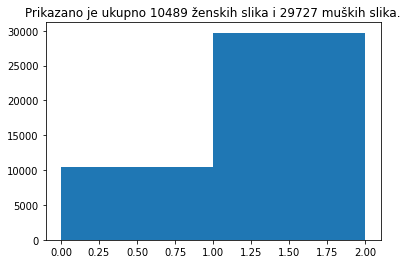

In [ ]:
#prikaz dataset-a koji nije izbalansiran
import matplotlib.pyplot as plt #koristi se za prikazivanje podataka u obliku histograma

gender = []
for g in data['gender'].values: #proverava se koji je pol u pitanju i dodaje odgovarajućem skupu
    if g == 'male':
        gender.append(1)
    else:
        gender.append(0)
            

plt.hist(gender, range(3))
plt.title('Prikazano je ukupno ' + str(len(gender) - sum(gender)) + ' ženskih slika i ' + str(sum(gender)) + ' muških slika.')
plt.show()

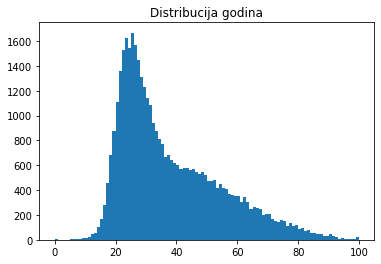

In [ ]:
#sledeći histogram daje prikaz distribucije godina
plt.hist(data['age'], range(101))
plt.title('Distribucija godina')
plt.show()

Nakon što su prikazani histogrami, sledeća ćelija služi za filtriranje i dalje procesiranje slika, kako bi detekcija godina mogla da se izvrši na zadovoljavajući način.

In [ ]:
# ovde se nalaze moduli koji su neophodni
import pandas as pd #služi za reprezentaciju podataka i manipulaciju sa istima
import numpy as np #višedimenzionalni nizovi i matrice
import cv2 #read i write image-a
import os  #sadrži funkcije za interakciju sa operativnim sistemom
from sklearn.model_selection import train_test_split 

#dataset se učitava
meta = pd.read_csv('meta.csv')

#neophodne samo godine
meta = meta.drop(['gender'], axis=1)

#dataset se filtrira (godine u rasponu od 0 do 101)
meta = meta[meta['age'] >= 0]
meta = meta[meta['age'] <= 101]

#podaci se transformišu u numpy array
meta = meta.values

#dataset se deli na trening i testni skup u odnosu 80% - 20%
D_train, D_test = train_test_split(meta, test_size=0.2, random_state=42)

#u ovom code block-u se kreiraju neophodni direktorijumi
for i in range(102):
    output_dir_train_male = 'dataset/age/train/' + str(i)
    output_dir_train_female = 'dataset/age/train/' + str(i)

    if not os.path.exists(output_dir_train_male):
        os.makedirs(output_dir_train_male)

    if not os.path.exists(output_dir_train_female):
        os.makedirs(output_dir_train_female)

    output_dir_test_male = 'dataset/age/test/' + str(i)
    output_dir_test_female = 'dataset/age/test/' + str(i)

    if not os.path.exists(output_dir_test_male):
        os.makedirs(output_dir_test_male)

    if not os.path.exists(output_dir_test_female):
        os.makedirs(output_dir_test_female)

#trening i testni dataset-ovi se kreiraju
counter = 0

for image in D_train:
    img = cv2.imread(image[1], 1)
    img = cv2.resize(img, (128,128)) #vrši se resize-ovanje slike na 128 piksela
    cv2.imwrite('dataset/age/train/' + str(image[0]) + '/' + str(counter) + '.jpg', img)
    print('Procesiranje: '+str(counter) +' Slika: ' + str(image[0]))
    counter += 1

counter = 0

for image in D_test:
    img = cv2.imread(image[1], 1)
    img = cv2.resize(img, (128,128))
    cv2.imwrite('dataset/age/test/' + str(image[0]) +  '/' + str(counter) + '.jpg', img)
    print('Procesiranje: '+str(counter) +' Slika: ' + str(image[0]))
    counter += 1

Streaming output truncated to the last 5000 lines.
Procesiranje: 3033 Slika: 34
Procesiranje: 3034 Slika: 16
Procesiranje: 3035 Slika: 79
Procesiranje: 3036 Slika: 31
Procesiranje: 3037 Slika: 30
Procesiranje: 3038 Slika: 45
Procesiranje: 3039 Slika: 61
Procesiranje: 3040 Slika: 29
Procesiranje: 3041 Slika: 28
Procesiranje: 3042 Slika: 63
Procesiranje: 3043 Slika: 66
Procesiranje: 3044 Slika: 77
Procesiranje: 3045 Slika: 42
Procesiranje: 3046 Slika: 22
Procesiranje: 3047 Slika: 34
Procesiranje: 3048 Slika: 34
Procesiranje: 3049 Slika: 21
Procesiranje: 3050 Slika: 57
Procesiranje: 3051 Slika: 59
Procesiranje: 3052 Slika: 30
Procesiranje: 3053 Slika: 78
Procesiranje: 3054 Slika: 82
Procesiranje: 3055 Slika: 34
Procesiranje: 3056 Slika: 37
Procesiranje: 3057 Slika: 38
Procesiranje: 3058 Slika: 56
Procesiranje: 3059 Slika: 23
Procesiranje: 3060 Slika: 20
Procesiranje: 3061 Slika: 56
Procesiranje: 3062 Slika: 26
Procesiranje: 3063 Slika: 28
Procesiranje: 3064 Slika: 62
Procesiranje: 3065 Sl

Kada se uspešno izvršilo procesiranje slika za godine, neophodno je izvršiti i za pol. Kod je dosta sličan kao u prethodnoj ćeliji.

In [ ]:
import pandas as pd 
import numpy as np 
import cv2
import os
from sklearn.model_selection import train_test_split

meta = pd.read_csv('meta.csv')

#ovde se briše kolona age, u prethodnoj ćeliji smo brisali kolonu gender
meta = meta.drop(['age'], axis=1)

#deli se dataset u odnosu 90% - 10%
D_train, D_test = train_test_split(meta, test_size=0.1, random_state=42)

#kako ne bi dolazilo do problema, usled nejednakosti u broju slika muškog i ženskog pola
#selektuje se isti broj slika u trening skupu
D_train_male = D_train[D_train['gender'] == 'male']
D_train_female = D_train[D_train['gender'] == 'female']

no_male = len(D_train_male)
no_female = len(D_train_female)

extra = D_train_male[no_female:]
D_train_male = D_train_male[0:no_female]

D_test = pd.concat((D_test, extra))

D_train = pd.concat((D_train_male, D_train_female))

#shuffling dataseta - dakle uzeće i izmešati ceo dataset
D_train = D_train.sample(frac=1)
D_test = D_test.sample(frac=1)

#kreiraju se neophodni direktorijumi
output_dir_train_male = 'dataset/gender/train/male'
output_dir_train_female = 'dataset/gender/train/female'

if not os.path.exists(output_dir_train_male):
    os.makedirs(output_dir_train_male)

if not os.path.exists(output_dir_train_female):
    os.makedirs(output_dir_train_female)

output_dir_test_male = 'dataset/gender/test/male'
output_dir_test_female = 'dataset/gender/test/female'

if not os.path.exists(output_dir_test_male):
    os.makedirs(output_dir_test_male)

if not os.path.exists(output_dir_test_female):
    os.makedirs(output_dir_test_female)

#loading slika u testni i trening skup
counter = 0

for image in D_train.values:
    img = cv2.imread(image[1], 1)
    img = cv2.resize(img, (128,128))
    if image[0] == 'male':
        cv2.imwrite('dataset/gender/train/male/' + str(counter) + '.jpg', img)
    else:
        cv2.imwrite('dataset/gender/train/female/' + str(counter) + '.jpg', img)
    print('Procesiranje: '+str(counter) +' Slika: ' + str(image[0]))
    counter += 1

counter = 0

for image in D_test.values:
    img = cv2.imread(image[1], 1)
    img = cv2.resize(img, (128,128))
    if image[0] == 'male':
        cv2.imwrite('dataset/gender/test/male/' + str(counter) + '.jpg', img)
    else:
        cv2.imwrite('dataset/gender/test/female/' + str(counter) + '.jpg', img)
    print('Procesiranje: '+str(counter) +' Slika: ' + str(image[0]))
    counter += 1

# **Model za detekciju pola kod osobe**

Za kreiranje datog modela korišćena je Keras biblioteka. Ona koristi grupu biblioteka nižeg nivoa, među kojima je i TensorFlow. Pojednostavljuje pisanje koda za duboke neuronske mreže. Implementacija je urađena u narednoj ćeliji.

In [ ]:
!pip install tensorflow
!pip install keras_applications

In [ ]:

#prvo što je neophodno, je import-ovati dependency-ije

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

#drugi korak jeste kreiranje modela 

#arhitektura se zasniva na sekvenci slojeva modela
#sekvencijalni model, koji podrazumeva niz slojeva modela
model = Sequential()

#MobileNetV2 jeste sledeći model koji se koristi
#model koji je učitan sa težinama koje su unapred učitane u ImageNet-u
mobile = MobileNetV2(include_top=False,
                          weights="imagenet", 
                          input_shape=(128,128,3),
                          pooling="max")

#mobile model se dodaje i konfiguriše se output sloj
#Dense je sloj neuronske mreže koji ima dva neurona, a tip funkcije koja ga aktivira je softmax
model.add(mobile)
model.add(Dense(units=2, activation="softmax"))

#model se kompajlira i navode se optimizatori
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['accuracy'])

#podaci o modelu se print-uju
print(model.summary())


#koristi se ImageDataGenerator klasa za data augmentaciju
#omogućenje augmentacije dok se model trenira, tako što rotira/zumira slike
train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.3)
test_datagen = ImageDataGenerator(rescale=1./255)

#čita se trening skup
#navodi se dimenzija treniranja 
#categorical - je zapravo 2D niz one-hot labela
train_generator = train_datagen.flow_from_directory('dataset/gender/train',
                                                    target_size=(128, 128),
                                                    batch_size=64,
                                                    class_mode='categorical')
#čita se testni skup
test_set = test_datagen.flow_from_directory('dataset/gender/test',
                                            target_size=(128, 128),
                                            batch_size=64,
                                            class_mode='categorical')

#za bolje rezultate vrši se prilagođavanje epohe
history1 = model.fit_generator(train_generator,
                    steps_per_epoch=100,
                    epochs=10,
                    validation_data=test_set,
                    validation_steps=50)

#poslednji korak podrazumeva čuvanje modela
model.save('weights/gender_mobile.h5')

9420800/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,226,434
Non-trainable params: 34,112
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


None
Found 18960 images belonging to 2 classes.
Found 21256 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
100/100 [==============================] - 69s 379ms/step - loss: 0.8526 - accuracy: 0.6998 - val_loss: 1.4169 - val_accuracy: 0.4131
Epoch 2/10
100/100 [==============================] - 34s 339ms/step - loss: 0.6300 - accuracy: 0.7777 - val_loss: 1.3635 - val_accuracy: 0.4678
Epoch 3/10
100/100 [==============================] - 33s 326ms/step - loss: 0.5554 - accuracy: 0.8023 - val_loss: 1.3355 - val_accuracy: 0.4959
Epoch 4/10
100/100 [==============================] - 31s 312ms/step - loss: 0.5091 - accuracy: 0.8238 - val_loss: 1.3482 - val_accuracy: 0.5084
Epoch 5/10
100/100 [==============================] - 32s 315ms/step - loss: 0.4949 - accuracy: 0.8197 - val_loss: 1.0171 - val_accuracy: 0.6275
Epoch 6/10
100/100 [==============================] - 31s 310ms/step - loss: 0.4663 - accuracy: 0.8369 - val_loss: 0.9310 - val_accuracy: 0.6644
Epoch 7/10
100/100 [==============================] - 32s 315ms/step - loss: 0.4421 - accuracy: 0.8400 - val_loss: 0.9650 - val_ac

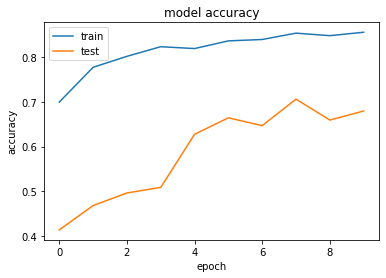

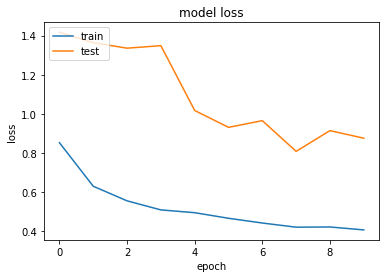

In [ ]:
#nakon što izvršavanje završeno radi se analiza performansi modela
import matplotlib.pyplot as plt

plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

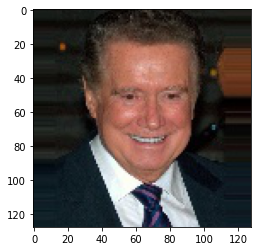

Muško


In [ ]:
#vrši se provera modela
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
 
def loadImage(filepath):
  test_img = image.load_img(filepath, target_size=(128, 128))
  test_img = image.img_to_array(test_img)
  test_img = np.expand_dims(test_img, axis = 0)
  test_img /= 255
  return test_img

picture = '/content/dataset/age/test/77/8031.jpg'
gender_pred = model.predict(loadImage(picture))
img = image.load_img(picture)                        
plt.imshow(img)
plt.show()
max=-1
count=0

if gender_pred[0][0]>gender_pred[0][1]:
  print('Žensko')
else:
  print('Muško')

#**Model za detekciju godina kod osobe**

Sledeći model predstavlja model koji se koristi kako bi se predvidele godine kod osobe sa slike. Model je kreiran na isti način kao i prethodni koji se bavio detekcijom pola osobe sa slike. 

In [ ]:
#importovanje dependency-ija
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

#kreiranje sekvencijalnog modela
model2 = Sequential()

#drugi tip modela koji se koristi InceptionResNetV2
mobile = InceptionResNetV2(include_top=False,
                          weights="imagenet", 
                          input_shape=(128,128,3),
                          pooling="max")

#dodaje se mobile model
#sloj neuronske mreže sa 102 neurona i tip funkcije aktivacije je softmax
model2.add(mobile)
model2.add(Dense(units=102, activation="softmax"))

#model se kompajlira i navode se optimizatori
model2.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['accuracy'])

#prikaz podataka
print(model2.summary())

#ImageDataGenerator se koristi za augmentaciju, koja se primenjuje dok se model trenira
train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.3)
test_datagen = ImageDataGenerator(rescale=1./255)

#trening skup se čita
train_generator = train_datagen.flow_from_directory('dataset/age/train',
                                                    target_size=(128, 128),
                                                    batch_size=64,
                                                    class_mode='categorical')
#testni skup se isčitava
test_set = test_datagen.flow_from_directory('dataset/age/test',
                                            target_size=(128, 128),
                                            batch_size=64,
                                            class_mode='categorical')

#zbog performantnosti se prilagođavaju epohe
history2 = model2.fit_generator(train_generator,
                    steps_per_epoch=100,
                    epochs=10,
                    validation_data=test_set,
                    validation_steps=25)

#model se čuva
model2.save('weights/age_inception.h5')

219070464/219055592 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 1536)             54336736  
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 102)               156774    
                                                                 
Total params: 54,493,510
Trainable params: 54,432,966
Non-trainable params: 60,544
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


None
Found 32129 images belonging to 102 classes.
Found 8033 images belonging to 102 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
100/100 [==============================] - 79s 464ms/step - loss: 4.6762 - accuracy: 0.0217 - val_loss: 4.7046 - val_accuracy: 0.0281
Epoch 2/10
100/100 [==============================] - 42s 418ms/step - loss: 4.2734 - accuracy: 0.0342 - val_loss: 4.2735 - val_accuracy: 0.0306
Epoch 3/10
100/100 [==============================] - 43s 423ms/step - loss: 4.1289 - accuracy: 0.0381 - val_loss: 4.1113 - val_accuracy: 0.0413
Epoch 4/10
100/100 [==============================] - 43s 426ms/step - loss: 4.0404 - accuracy: 0.0428 - val_loss: 4.0797 - val_accuracy: 0.0338
Epoch 5/10
100/100 [==============================] - 42s 417ms/step - loss: 3.9730 - accuracy: 0.0447 - val_loss: 4.0311 - val_accuracy: 0.0375
Epoch 6/10
100/100 [==============================] - 42s 416ms/step - loss: 3.9396 - accuracy: 0.0461 - val_loss: 3.9993 - val_accuracy: 0.0388
Epoch 7/10
100/100 [==============================] - 42s 421ms/step - loss: 3.8806 - accuracy: 0.0508 - val_loss: 3.9795 - val_ac

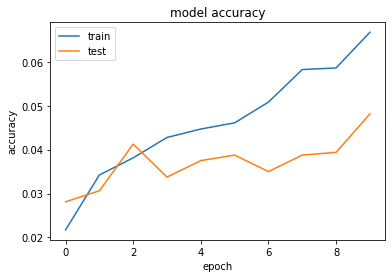

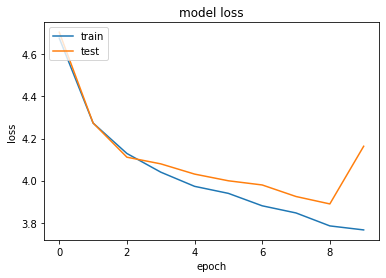

In [ ]:
#analiziraju se performanse modela
import matplotlib.pyplot as plt

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

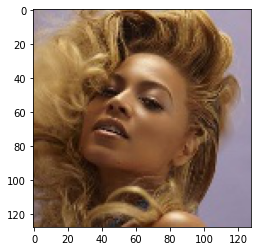

26
25-49 godina


In [ ]:
#rezultati se proveravaju
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
 
def loadImage(filepath):
  test_img = image.load_img(filepath, target_size=(128, 128))
  test_img = image.img_to_array(test_img)
  test_img = np.expand_dims(test_img, axis = 0)
  test_img /= 255
  return test_img

picture = '/content/dataset/age/test/29/8029.jpg'  
age_pred= model2.predict(loadImage(picture))
img = image.load_img(picture)                        
plt.imshow(img)
plt.show()
max=-1
count=0

for i in age_pred[0]:
  if i>max:
    max = i
    temp = count
  count+=1

print(temp) 
if temp in range(0, 24):
  print('0-24 godina')
if temp in range(25, 49):
  print('25-49 godina')
if temp in range(50, 74):
  print('50-74 godina')
if temp in range(75, 99):
  print('75-99 godina')
if temp in range(91, 101):
  print('91-101 godina')

#**Model za detekciju emocija kod osobe**

Kod modela za detekciju emocija primenjen je DeepFace algoritam. Takođe je izvršen import cv2 modula.

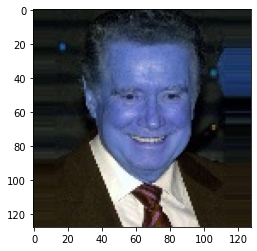

In [ ]:
import cv2
from deepface import DeepFace
img = cv2.imread('/content/dataset/age/test/77/8031.jpg')
import matplotlib.pyplot as plt
plt.imshow(img) #prikazaće plavu nijasnu 

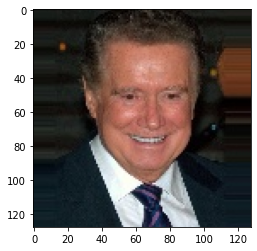

In [ ]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) #vraćanje slike na prirodan ten

In [ ]:
predictions = DeepFace.analyze(img) #analiza slike

Action: race: 100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


In [ ]:
predictions #prikaz predviđenih vrednosti za definisana obeležja, od interesa samo dominant_emotion

{'age': 41,
 'dominant_emotion': 'happy',
 'dominant_race': 'white',
 'emotion': {'angry': 0.0002098340473821736,
  'disgust': 1.2649729874691928e-08,
  'fear': 7.318456063387657e-07,
  'happy': 93.0005133152008,
  'neutral': 6.996974349021912,
  'sad': 0.0019360271835466847,
  'surprise': 0.0003665487383841537},
 'gender': 'Man',
 'race': {'asian': 14.974751470968215,
  'black': 0.0700642221924944,
  'indian': 0.338516357974193,
  'latino hispanic': 7.3873367838464254,
  'middle eastern': 3.562101934081431,
  'white': 73.66723261280254},
 'region': {'h': 68, 'w': 68, 'x': 35, 'y': 23}}

In [ ]:
type(predictions)

dict

In [ ]:
predictions['dominant_emotion']

'happy'

In [ ]:
#upotreba cascade klasifikatora
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [ ]:
print(faceCascade.empty())

False


In [ ]:
#pokušaj da se kreira zeleni četvorougao oko lica osobe
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = faceCascade.detectMultiScale(gray,1.1,4)

for (x, y, w, h) in faces:
  cv2.rectangle(img, (x,y), (x+w, y+h), (0, 255, 0), 2)

In [ ]:
#dodavanje neophodnog teksta raspoloženja na slici
font = cv2.FONT_HERSHEY_SIMPLEX

cv2.putText(img, 
            predictions['dominant_emotion'],
            (0,120),
            font,
            1,
            (0, 0, 255),
            2,
            cv2.LINE_4)

array([[[20, 23, 21],
        [20, 23, 21],
        [20, 23, 21],
        ...,
        [26, 31, 30],
        [26, 31, 30],
        [26, 31, 30]],

       [[27, 30, 28],
        [27, 30, 28],
        [27, 30, 28],
        ...,
        [27, 32, 31],
        [27, 31, 32],
        [27, 32, 31]],

       [[24, 28, 23],
        [24, 28, 23],
        [24, 28, 23],
        ...,
        [29, 33, 34],
        [29, 32, 36],
        [29, 33, 34]],

       ...,

       [[36, 29, 12],
        [36, 29, 12],
        [36, 29, 12],
        ...,
        [37, 29, 12],
        [37, 28, 14],
        [37, 29, 12]],

       [[37, 30, 13],
        [37, 30, 13],
        [37, 30, 13],
        ...,
        [42, 31, 17],
        [42, 30, 18],
        [42, 31, 17]],

       [[38, 31, 14],
        [38, 31, 14],
        [38, 31, 14],
        ...,
        [40, 28, 16],
        [40, 28, 16],
        [40, 28, 16]]], dtype=uint8)

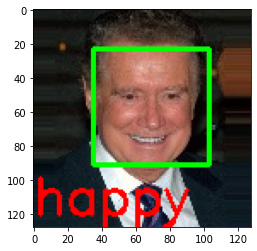

In [ ]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

#**Zaključak**

Rad na projektu je bio zanimljiv, kao i sam dataset.  Pošto je dataset bio pun "škartova", odnosno loših fotgrafija, bilo je potrebno dosta vremena kako bi iste lepo isfiltrirale. 
Modeli su se kreirali i trenirali upotrebom Keras bilblioteke.
Modeli su testirani uz pomoć testnih podataka i prilično su se lepo pokazali na delu. 
Najveći izazov u projektu predstavljala je detekcija emocija, s obzirom da se u dataset-u ne pojavljuje. Ali sve je rešeno uz pomoć prijatelja koji se zove Google.

Svaki projekat donosi neko novo iskustvo, pogotovo ovaj, jer otvara nova vrata ka sferi machine learning-a, koja postaje iz godine u godinu sve popularnija.

#**Reference**

[1] https://sr.m.wikipedia.org/sr-ec/%D0%94%D1%83%D0%B1%D0%BE%D0%BA%D0%BE_%D1%83%D1%87%D0%B5%D1%9A%D0%B5

[2] https://www.youtube.com/watch?v=fkgpvkqcoJc&ab_channel=DeepLearning_by_PhDScholar

[3] https://keras.io/

[4] Materijali sa vežbi

[5] Korišćeni dataset - https://drive.google.com/file/d/1ztlCf2S68-k4ulB05gWsxGZtbU98jIx_/view?usp=sharing